# Bucle de Entrenamiento GAN

Este cuaderno implementa el bucle de entrenamiento para la GAN (Generador y Discriminador).
Se cargan los datos, se definen los modelos y optimizadores, y se ejecuta el entrenamiento por épocas.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os
import pandas as pd

# Añadir el directorio raíz al path para importar módulos src
sys.path.append(os.path.abspath('..'))

from src.data_loader import download_data
from src.preprocessing import DataPreprocessor, create_sequences

## 1. Carga y Preparación de Datos

Cargamos los datos usando los módulos de `src` y preparamos el DataLoader.

In [2]:
# Configuración
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-11-29'
SEQ_LEN = 24
BATCH_SIZE = 32
DATA_DIR = '../data/raw'

# 1. Cargar datos (existentes o descargar)
csv_filename = f"{TICKER}_{START_DATE}_{END_DATE}.csv"
csv_path = os.path.join(DATA_DIR, csv_filename)

if os.path.exists(csv_path):
    print(f"Cargando datos existentes desde: {csv_path}")
    # Cargar CSV manejando el formato de yfinance (mismo que en EDA)
    df = pd.read_csv(csv_path, header=0, skiprows=[1, 2], index_col=0, parse_dates=True)
    df.index.name = 'Date' # Asegurar nombre del índice
else:
    print(f"Datos no encontrados. Descargando...")
    df = download_data(TICKER, START_DATE, END_DATE, save_dir=DATA_DIR)

# 2. Preprocesar
preprocessor = DataPreprocessor()
data_scaled = preprocessor.fit_transform(df, ['Close'])

# 3. Crear secuencias
sequences = create_sequences(data_scaled, SEQ_LEN)

# 4. Convertir a Tensor y crear DataLoader
X_train = torch.tensor(sequences, dtype=torch.float32)
dataset = TensorDataset(X_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Datos de entrenamiento: {X_train.shape}")

Cargando datos existentes desde: ../data/raw/AAPL_2015-01-01_2025-11-29.csv
Datos de entrenamiento: torch.Size([2720, 24, 1])


## 2. Definición de Modelos

Copiamos las definiciones de Generador y Discriminador del paso anterior.

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return self.sigmoid(output)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]
        output = self.linear(last_hidden)
        return self.sigmoid(output)

## 3. Inicialización y Configuración

Definimos hiperparámetros, función de pérdida y optimizadores.

In [4]:
# Hiperparámetros
NOISE_DIM = 10
HIDDEN_DIM = 32
FEATURE_DIM = 1
NUM_EPOCHS = 100
LR = 0.001

# Dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Instanciar modelos
generator = Generator(input_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM, output_dim=FEATURE_DIM).to(device)
discriminator = Discriminator(input_dim=FEATURE_DIM, hidden_dim=HIDDEN_DIM, output_dim=1).to(device)

# Función de Pérdida
criterion = nn.BCELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=LR)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR)

Usando dispositivo: cpu


## 4. Bucle de Entrenamiento

Entrenamos el GAN alternando entre el Discriminador y el Generador.

In [5]:
G_losses = []
D_losses = []

print("Iniciando entrenamiento...")

for epoch in tqdm(range(NUM_EPOCHS)):
    for i, (real_data,) in enumerate(dataloader):
        # Preparar datos reales
        real_data = real_data.to(device)
        batch_size = real_data.size(0)
        
        # Etiquetas
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Entrenar Discriminador
        # ---------------------
        optimizer_D.zero_grad()

        # Loss con datos reales
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Generar datos falsos
        z = torch.randn(batch_size, SEQ_LEN, NOISE_DIM).to(device)
        fake_data = generator(z)

        # Loss con datos falsos
        outputs = discriminator(fake_data.detach()) # Detach para no entrenar G aquí
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_D.step()
        d_loss = d_loss_real + d_loss_fake

        # -----------------
        #  Entrenar Generador
        # -----------------
        optimizer_G.zero_grad()

        # Queremos que el discriminador crea que son reales
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        
        g_loss.backward()
        optimizer_G.step()

    # Guardar pérdidas
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print("Entrenamiento completado.")

Iniciando entrenamiento...


 10%|█         | 10/100 [00:08<01:18,  1.14it/s]

Epoch [10/100] | D Loss: 1.1742 | G Loss: 1.6697


 20%|██        | 20/100 [00:17<01:08,  1.18it/s]

Epoch [20/100] | D Loss: 1.3826 | G Loss: 0.6922


 30%|███       | 30/100 [00:25<00:59,  1.17it/s]

Epoch [30/100] | D Loss: 1.2616 | G Loss: 0.7618


 40%|████      | 40/100 [00:34<00:51,  1.17it/s]

Epoch [40/100] | D Loss: 1.2947 | G Loss: 1.3458


 50%|█████     | 50/100 [00:42<00:41,  1.22it/s]

Epoch [50/100] | D Loss: 1.4008 | G Loss: 1.0564


 60%|██████    | 60/100 [00:50<00:33,  1.20it/s]

Epoch [60/100] | D Loss: 0.9689 | G Loss: 1.0231


 70%|███████   | 70/100 [00:59<00:24,  1.21it/s]

Epoch [70/100] | D Loss: 0.6099 | G Loss: 1.4273


 80%|████████  | 80/100 [01:07<00:16,  1.20it/s]

Epoch [80/100] | D Loss: 0.9407 | G Loss: 1.1009


 90%|█████████ | 90/100 [01:16<00:08,  1.22it/s]

Epoch [90/100] | D Loss: 1.0600 | G Loss: 1.0170


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]

Epoch [100/100] | D Loss: 0.9817 | G Loss: 1.0431
Entrenamiento completado.


## 5. Visualización de Resultados

Graficamos las pérdidas y comparamos una serie generada con una real.

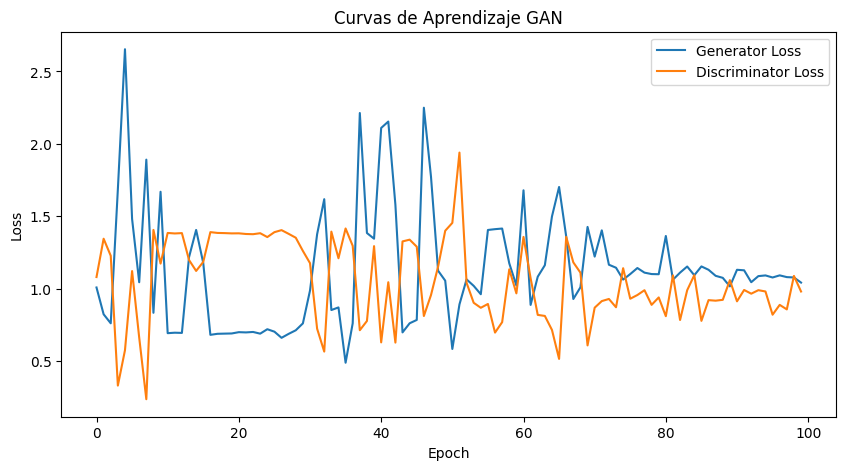

In [6]:
# Gráfica de Pérdidas
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.title("Curvas de Aprendizaje GAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

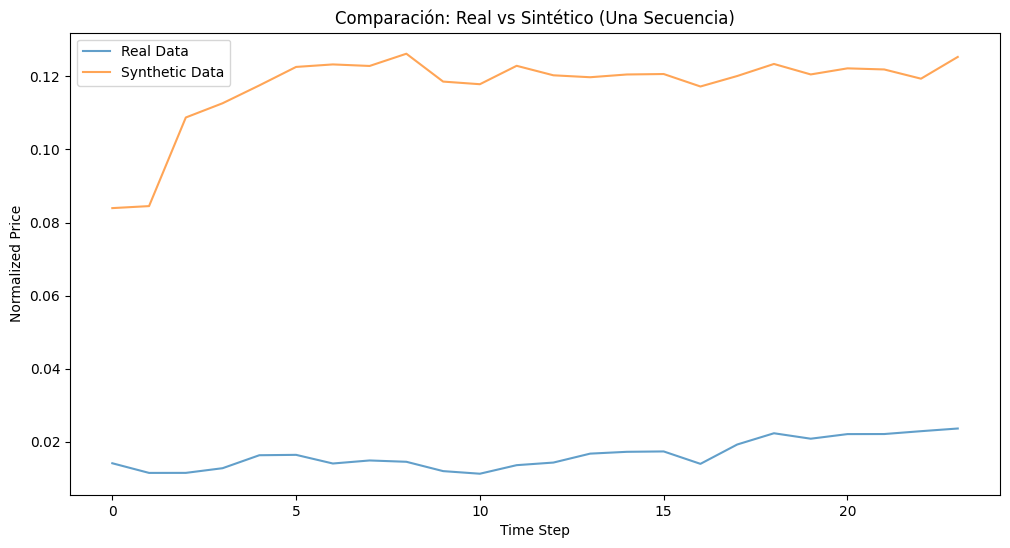

In [7]:
# Generar una muestra sintética
generator.eval()
with torch.no_grad():
    z_sample = torch.randn(1, SEQ_LEN, NOISE_DIM).to(device)
    generated_seq = generator(z_sample).cpu().numpy().squeeze()

# Obtener una muestra real para comparar
real_seq = X_train[0].numpy().squeeze()

# Graficar comparación
plt.figure(figsize=(12, 6))
plt.plot(real_seq, label="Real Data", alpha=0.7)
plt.plot(generated_seq, label="Synthetic Data", alpha=0.7)
plt.title("Comparación: Real vs Sintético (Una Secuencia)")
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

## 6. Guardar Modelo

Guardamos los pesos del generador entrenado para uso futuro.

In [8]:
save_path = "../models/generator_final.pth"
torch.save(generator.state_dict(), save_path)
print(f"Modelo guardado en: {save_path}")

Modelo guardado en: ../src/generator_final.pth
